# K-means Clustering

In this notebook, we will be performing K-means clustering on the biomarker set and try to group the VAP patients to distict endotypes.

## 1. Import necessary libraries, have function definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Determine the optimal number of clusters using the Elbow Method and Silhouette Scores.
# reference: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
def find_optimal_clusters(data, k_range=(2, 15), random_state=42):
    
    inertia = []
    silhouette_scores = []
    K = range(k_range[0], k_range[1])

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Elbow method plot
    plt.figure(figsize=(10, 5))
    plt.plot(K, inertia, 'bo-', label='Inertia')
    plt.xlabel('# Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.legend()
    plt.show()

    # Silhouette Scores plot
    plt.figure(figsize=(10, 5))
    plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
    plt.xlabel('# Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores Method')  
    plt.legend()
    plt.show()

In [3]:
# Performs silhouette analysis and visualizes cluster separation
# reference: https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette_analysis(X, range_n_clusters=[2, 3, 4, 5, 6], random_state=30):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The first subplot is the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = clusterer.fit_predict(X)

        # Compute silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg:.3f}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Extract silhouette scores for samples belonging to cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with cluster numbers
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute new y_lower for next plot
            y_lower = y_upper + 10  # 10 for spacing between clusters

        ax1.set_title("Silhouette plot for various clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Second subplot: visualization of actual clusters
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        ax2.set_title("Visualization of the clustered data")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}",
                     fontsize=14, fontweight="bold")

    plt.show()


In [4]:
# Perform K-Means clustering and assign cluster labels to the dataset.
def assign_clusters(data, optimal_k, random_state=30):
    df = data.copy()
    kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
    df['Cluster'] = kmeans.fit_predict(df)
    return df


In [5]:
# Perform PCA to reduce dimensions and visualize clusters in 2D.
def visualize_clusters_2D_pca(df, cluster_column='Cluster', n_components=2, colors=None):
    numeric_data = df.drop(columns=[cluster_column])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(numeric_data)

    # Convert to DataFrame for visualization
    pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df[cluster_column] = df[cluster_column].values

    # Plot PCA scatter plot
    palette = colors if colors else "viridis"
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        x=pca_df['PC1'],
        y=pca_df['PC2'],
        hue=pca_df[cluster_column],
        palette=palette,
    )
    plt.title("Visualization of Clusters (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title=cluster_column)
    plt.show()


In [6]:
# Perform PCA to reduce dimensions and visualize clusters in 3D.
def visualize_clusters_3D_pca(df, cluster_column='Cluster', n_components=3, colors=None):
    numeric_data = df.drop(columns=[cluster_column])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(numeric_data)

    # Convert to DataFrame for visualization
    pca_df = pd.DataFrame(pca_data, columns=[f'PCA{i+1}' for i in range(n_components)])
    pca_df[cluster_column] = df[cluster_column].values

    # Plot 3D scatter plot
    palette = colors if colors else "viridis"
    fig = px.scatter_3d(
        pca_df, 
        x='PCA1', 
        y='PCA2', 
        z='PCA3', 
        color=cluster_column,
        title='Visualization of Clusters (3D)',
        color_continuous_scale=palette,
    )
    
    fig.show()


In [7]:
# Visualize standardized biomarker values across clusters and compute differences between two specified clusters.
def plot_biomarker_clusters(df, cluster_a, cluster_b, cluster_column='Cluster', colors=None, label_rotation=90):
    
    # Check if both clusters exist in the dataset
    unique_clusters = df[cluster_column].unique()
    if cluster_a not in unique_clusters or cluster_b not in unique_clusters:
        print(f"Error: Cluster {cluster_a} or Cluster {cluster_b} not found in the dataset.")

    else:
        # Melt the DataFrame for visualization
        melted_df = df.melt(id_vars=[cluster_column], var_name='Biomarker', value_name='Standardized Value')

        # Calculate the difference in mean standardized values between the selected clusters and convert it into a df
        cluster_means = df.groupby(cluster_column).mean()
        cluster_difference = cluster_means.loc[cluster_a] - cluster_means.loc[cluster_b]
        cluster_difference_df = cluster_difference.reset_index()
        cluster_difference_df.columns = ['Biomarker', f'Difference_Cluster_{cluster_a}_vs_{cluster_b}']

        # Reorder the melted DataFrame based on the descending order of differences and plot the line chart
        biomarker_order = cluster_difference_df.sort_values(by=f'Difference_Cluster_{cluster_a}_vs_{cluster_b}', ascending=False)['Biomarker'].tolist()
        melted_df['Biomarker'] = pd.Categorical(melted_df['Biomarker'], categories=biomarker_order, ordered=True)

        palette = colors if colors else "viridis"
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=melted_df,
            x='Biomarker',
            y='Standardized Value',
            hue=cluster_column,
            palette=palette,
            marker='o'
        )

        # Customize the plot
        plt.title(f"Biomarkers by Cluster")
        plt.xlabel("Biomarker")
        plt.ylabel("Standardized Value")
        plt.xticks(rotation=label_rotation)
        plt.legend(title='Cluster')
        plt.grid(True)
        plt.show()


In [8]:
# Trains a LASSO logistic regression model with cross-validation on the training data.
def train_lasso_model(X_train, y_train):

    # Standardize the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Define a LASSO model (LogisticRegression with L1 penalty)
    lasso = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
    
    # Grid search to find best regularization strength (C)
    param_grid = {"C": np.logspace(-3, 3, 10)}
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X_train_scaled, y_train)
    
    best_C = grid_search.best_params_["C"]
    best_model = LogisticRegression(penalty="l1", solver="liblinear", C=best_C, max_iter=1000)
    best_model.fit(X_train_scaled, y_train)
    
    # Identify important biomarkers
    selected_biomarkers = np.array(X_train.columns)[best_model.coef_[0] != 0]
    lasso_results = pd.DataFrame({
        "Biomarker": X_train.columns,
        "Coefficient": best_model.coef_[0]
    })
    return best_model, scaler, selected_biomarkers, lasso_results

In [9]:
# Evaluate the trained LASSO model on the validation set using ROC AUC.
def evaluate_lasso_model(model, scaler, X_val, y_val):
    X_val_scaled = scaler.transform(X_val)
    y_val_pred_prob = model.predict_proba(X_val_scaled)
    
    # If binary classification , use the probability of the positive class
    if y_val_pred_prob.shape[1] == 2:
        auc_val = roc_auc_score(y_val, y_val_pred_prob[:, 1])
    else:
        auc_val = roc_auc_score(y_val, y_val_pred_prob, multi_class="ovr")
    return auc_val

## 2. Load the data

In [10]:
# Load the biomarker data that we cleaned and scaled in N1_biomarker_data_cleaning.py
biomarker_df_file_path = "../data/clean_data/scaled_biomarker_data.csv"
biomarker_df = pd.read_csv(biomarker_df_file_path)
biomarker_df.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IL-8_chemo_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_GM-CSF_V1_imputed,balf_IL-12/IL-23p40_V1_imputed,balf_IL-15_V1_imputed,balf_IL-16_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed,balf_VEGF_V1_imputed,balf_G-CSF_V1_imputed,balf_PD-L1_V1_imputed,balf_IL-6_proinf_V1_imputed,balf_sRAGE_V1_imputed,balf_TNF-RI_V1_imputed
0,-1.470130,-1.498284,-0.246658,-1.129279,-0.614070,-0.030338,-0.866099,-0.440824,-0.655745,-1.162979,0.375604,-0.695447,-1.099571,0.286584,0.352247,-1.095234,-0.887325,-1.598728,-0.288758,-1.412866
1,0.803770,0.911863,1.228127,-3.101678,-2.734490,-2.711906,-1.388472,-1.679053,-0.042735,1.728370,0.789723,1.435168,2.252914,0.530009,0.845505,1.136749,1.368696,1.138960,0.049796,0.753702
2,0.553875,0.576147,-0.224706,0.996641,-0.032357,0.089440,-0.522827,-0.620921,-0.935185,0.064120,-1.590510,0.092549,-0.101333,-0.558272,0.403123,0.351343,-0.339183,1.136237,0.310366,0.560863
3,-1.671626,-0.889214,-0.380679,-0.493922,-0.726075,0.811831,0.090998,-0.737614,-0.720736,-0.498054,0.685410,-1.272986,-0.815376,-0.952069,-0.559623,-0.522124,-0.689435,-1.015348,-0.573650,-1.044524
4,1.005517,1.199630,-0.851120,0.776083,0.854145,-0.590079,-0.351586,-0.139260,-0.981345,0.360495,-1.226081,1.447499,0.130569,0.644662,1.273656,0.558921,-0.019721,0.442616,-1.536270,0.599358


In [11]:
# Load the biomarker data that we cleaned, removed highly correlated fields and scaled in N1_biomarker_data_cleaning.py
biomarker_df_notcorrelated_file_path = "../data/clean_data/scaled_biomarker_data_notcorrelated.csv"
biomarker_df_notcorrelated = pd.read_csv(biomarker_df_notcorrelated_file_path)
biomarker_df_notcorrelated.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_IL-15_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed
0,-0.492915,-0.679906,-0.364026,-0.398849,-0.526441,-0.291255,-0.222259,0.109407,-0.320342,-0.083610
1,0.109179,0.444489,0.703246,-0.426586,-0.820222,-0.300766,-0.271759,0.528131,1.692955,0.079621
2,-0.070704,-0.171665,-0.357568,-0.343292,-0.462556,-0.279299,-0.234603,-1.061765,-0.237674,-0.482387
3,-0.500018,-0.667498,-0.400267,-0.404188,0.343985,-0.233626,-0.241308,0.414804,-0.305904,-0.604054
4,0.305407,1.536762,-0.492616,0.012145,-0.704107,-0.270526,-0.194698,-0.918226,-0.199417,0.166189


## 3. Clustering

First, let us perform clustering on the biomarket dataset that also have correlated columns


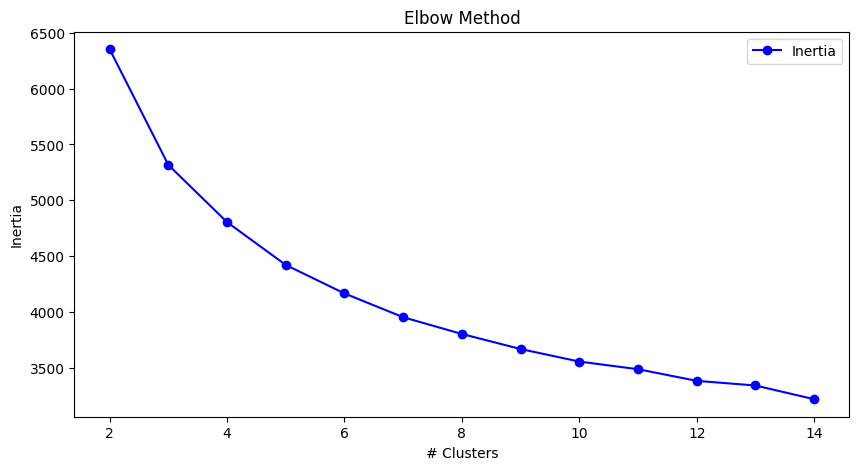

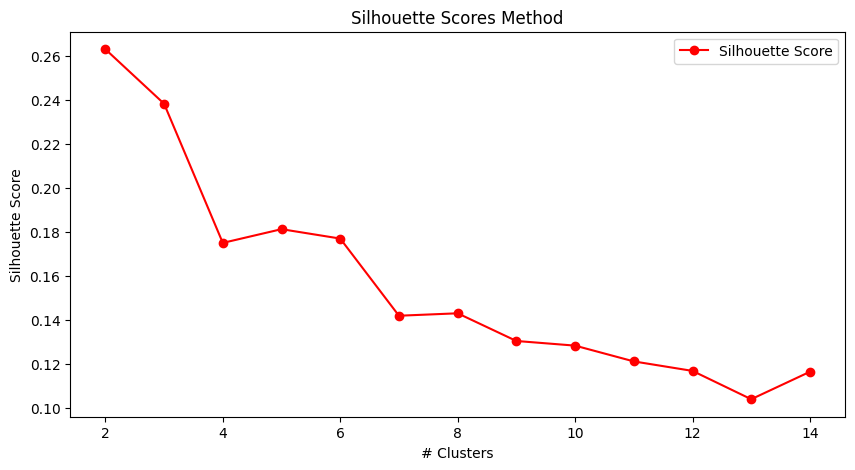

In [12]:
find_optimal_clusters(biomarker_df)

For n_clusters = 2, The average silhouette_score is: 0.263
For n_clusters = 3, The average silhouette_score is: 0.237
For n_clusters = 4, The average silhouette_score is: 0.175
For n_clusters = 5, The average silhouette_score is: 0.185
For n_clusters = 6, The average silhouette_score is: 0.158


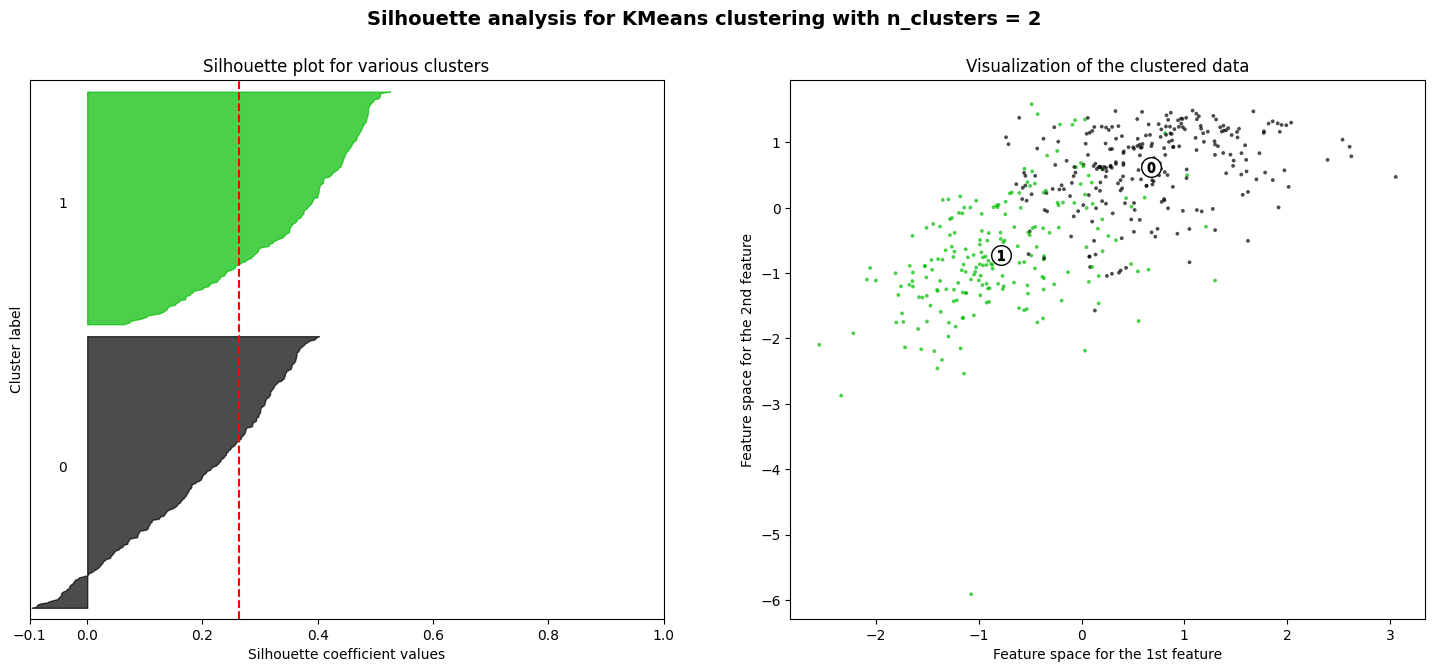

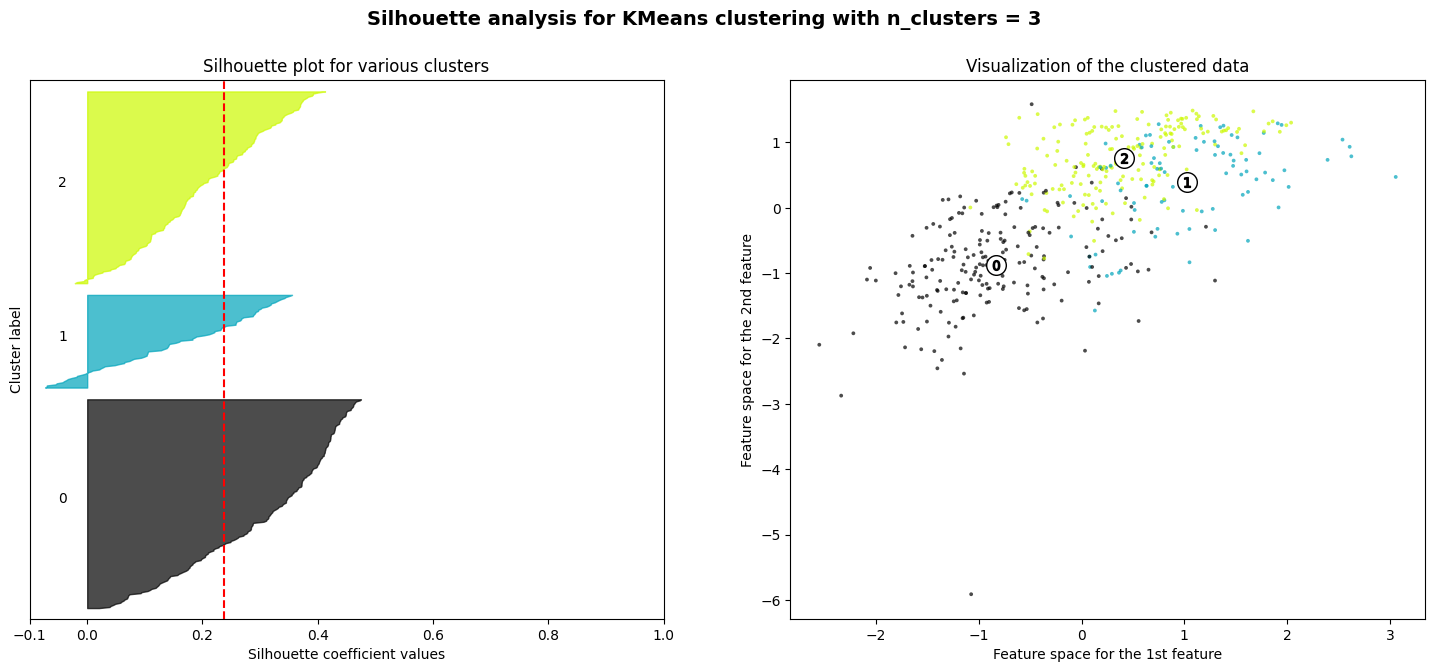

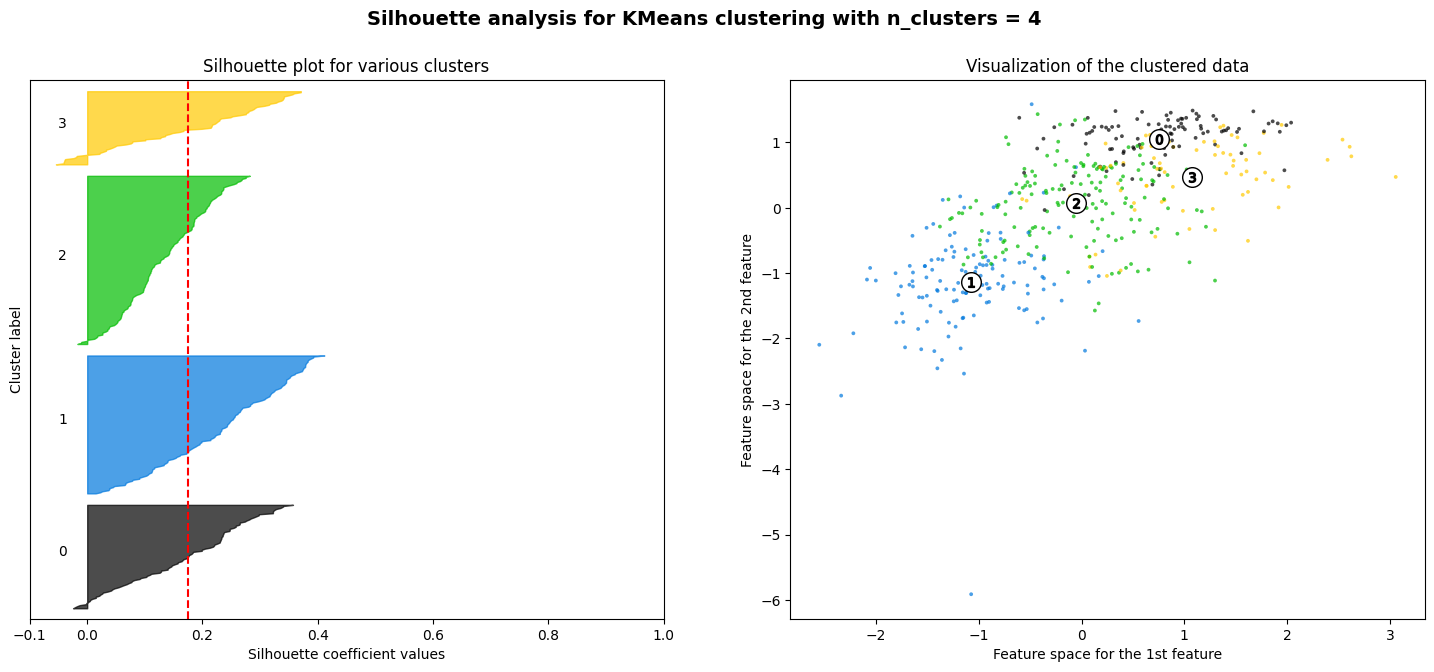

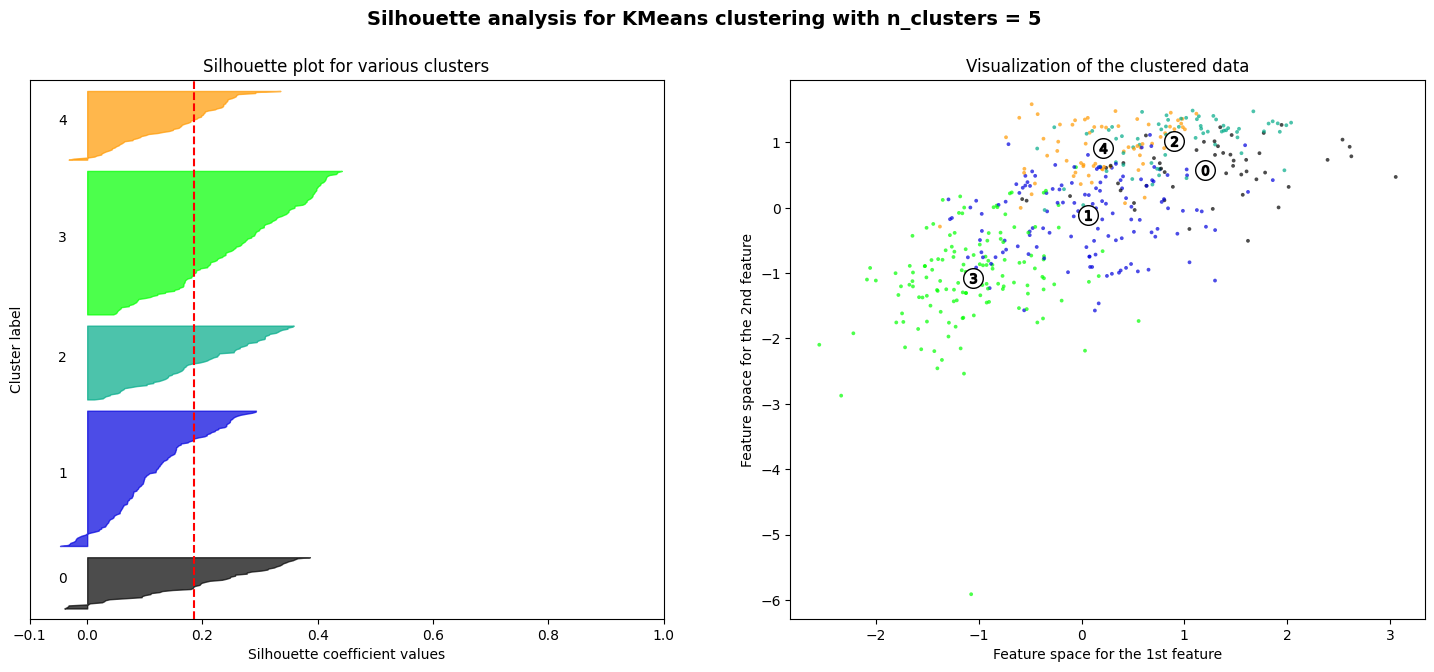

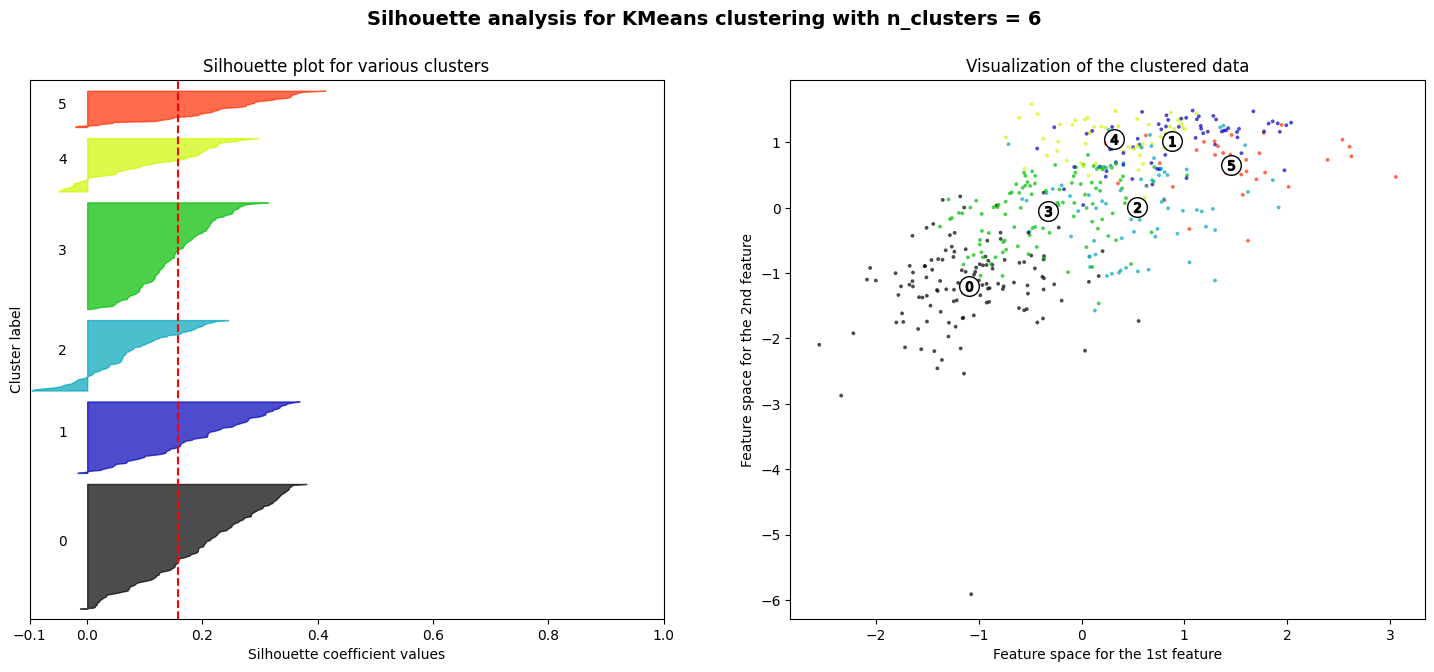

In [13]:
silhouette_analysis(biomarker_df.values)

k = 2 seeems like an optimal 'k' (has the highest value). 

Let us now perform K-Means clustering and assign cluster labels to the biomarker data.

In [14]:
biomarker_df_with_clusters = assign_clusters(biomarker_df, 2)
biomarker_df_with_clusters.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IL-8_chemo_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_GM-CSF_V1_imputed,balf_IL-12/IL-23p40_V1_imputed,...,balf_IL-16_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed,balf_VEGF_V1_imputed,balf_G-CSF_V1_imputed,balf_PD-L1_V1_imputed,balf_IL-6_proinf_V1_imputed,balf_sRAGE_V1_imputed,balf_TNF-RI_V1_imputed,Cluster
0,-1.470130,-1.498284,-0.246658,-1.129279,-0.614070,-0.030338,-0.866099,-0.440824,-0.655745,-1.162979,...,-0.695447,-1.099571,0.286584,0.352247,-1.095234,-0.887325,-1.598728,-0.288758,-1.412866,1
1,0.803770,0.911863,1.228127,-3.101678,-2.734490,-2.711906,-1.388472,-1.679053,-0.042735,1.728370,...,1.435168,2.252914,0.530009,0.845505,1.136749,1.368696,1.138960,0.049796,0.753702,0
2,0.553875,0.576147,-0.224706,0.996641,-0.032357,0.089440,-0.522827,-0.620921,-0.935185,0.064120,...,0.092549,-0.101333,-0.558272,0.403123,0.351343,-0.339183,1.136237,0.310366,0.560863,0
3,-1.671626,-0.889214,-0.380679,-0.493922,-0.726075,0.811831,0.090998,-0.737614,-0.720736,-0.498054,...,-1.272986,-0.815376,-0.952069,-0.559623,-0.522124,-0.689435,-1.015348,-0.573650,-1.044524,1
4,1.005517,1.199630,-0.851120,0.776083,0.854145,-0.590079,-0.351586,-0.139260,-0.981345,0.360495,...,1.447499,0.130569,0.644662,1.273656,0.558921,-0.019721,0.442616,-1.536270,0.599358,0


Let us now visualize the clusters in 2D and 3D to see if it makes sense.

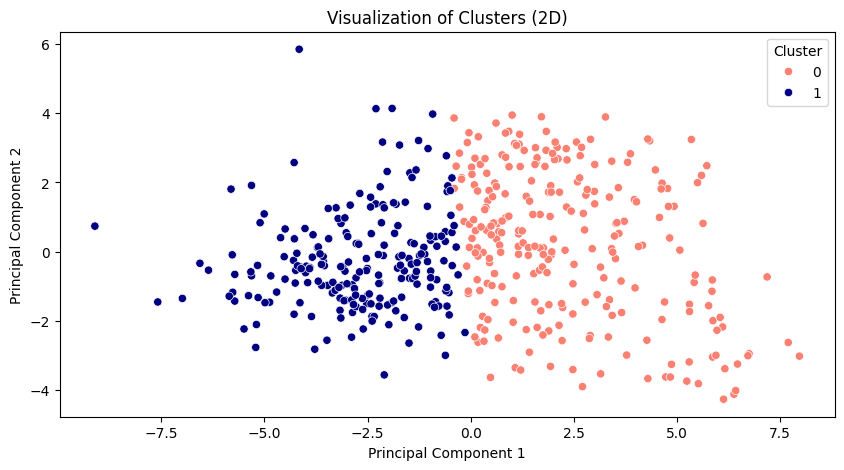

In [15]:
color_palette = ["salmon", "navy"]#, "green"]
visualize_clusters_2D_pca(biomarker_df_with_clusters, colors=color_palette)

In [16]:
visualize_clusters_3D_pca(biomarker_df_with_clusters, colors=color_palette)

I now want to visualize thw standardized biomarker values across clusters using a line chart

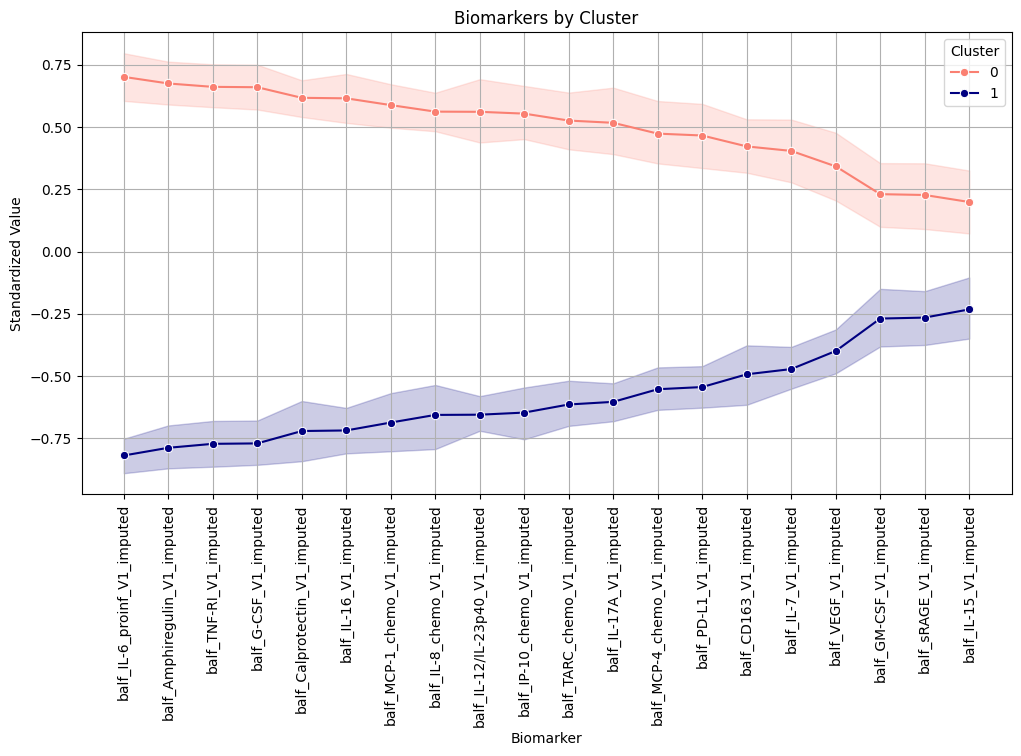

In [17]:
plot_biomarker_clusters(biomarker_df_with_clusters, cluster_a=0, cluster_b=1, colors=color_palette)

Now, I want to compare the k between the this dataset and the dataset where highly correlated values were removed!

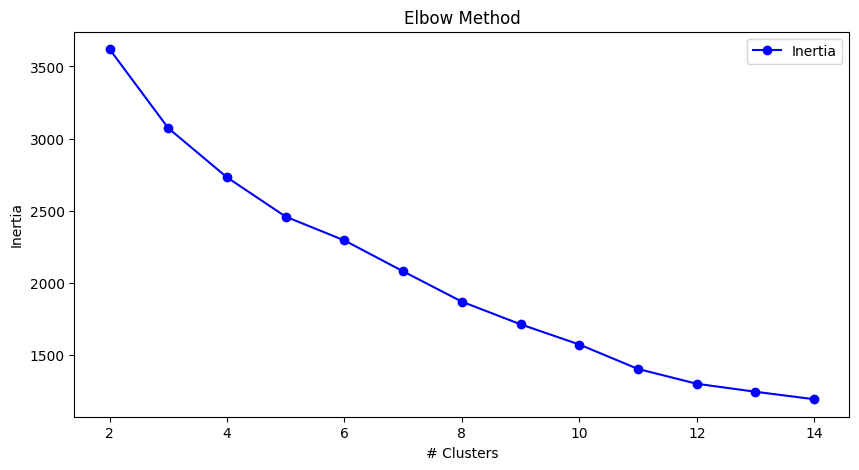

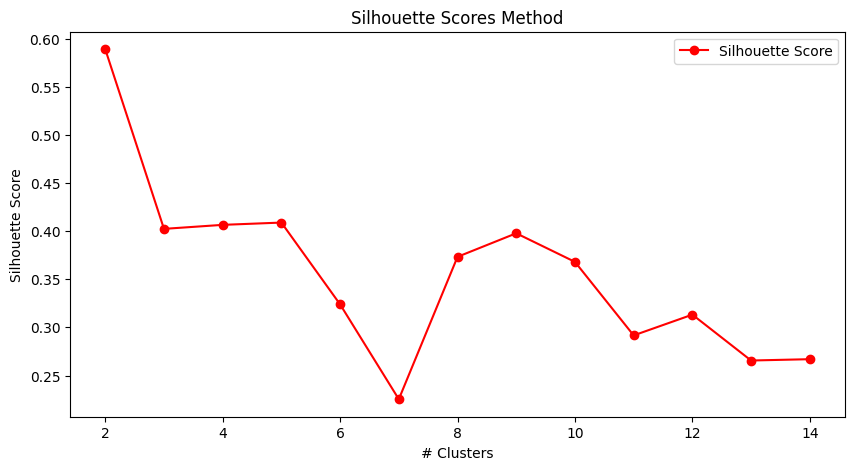

In [18]:
find_optimal_clusters(biomarker_df_notcorrelated)

For n_clusters = 2, The average silhouette_score is: 0.593
For n_clusters = 3, The average silhouette_score is: 0.404
For n_clusters = 4, The average silhouette_score is: 0.407
For n_clusters = 5, The average silhouette_score is: 0.403
For n_clusters = 6, The average silhouette_score is: 0.417


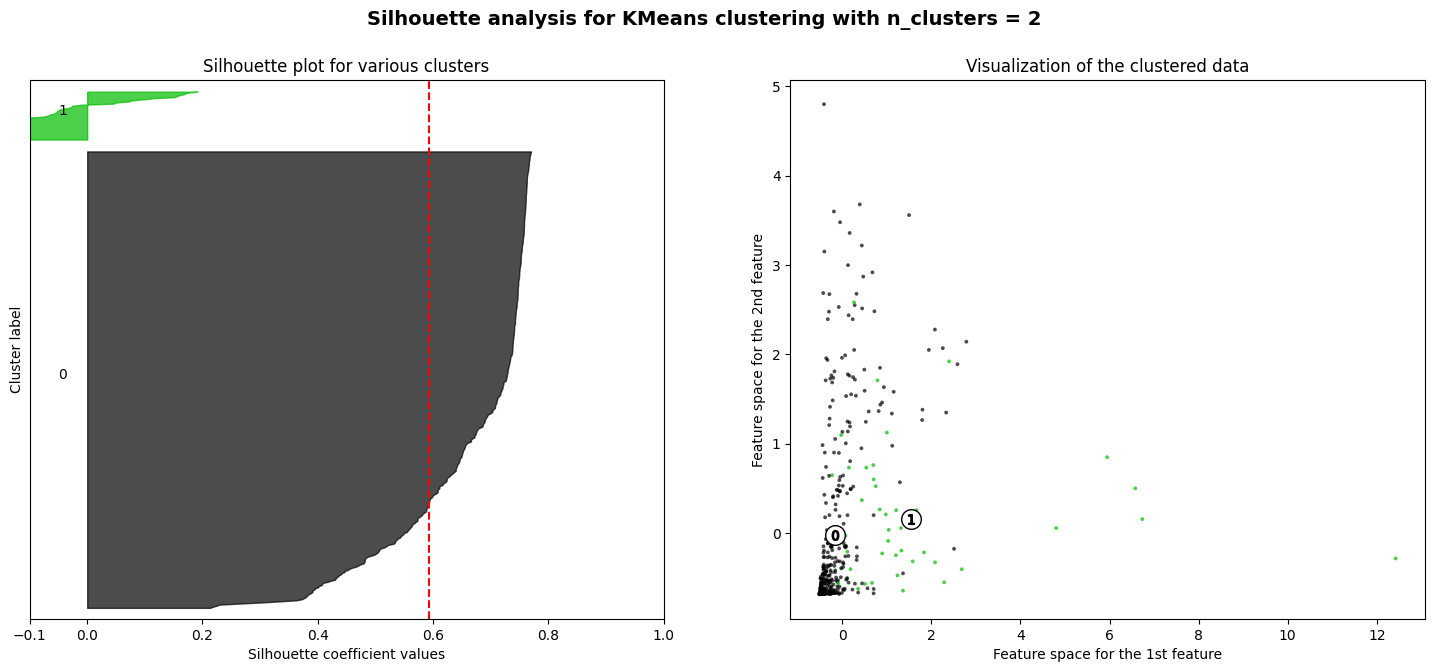

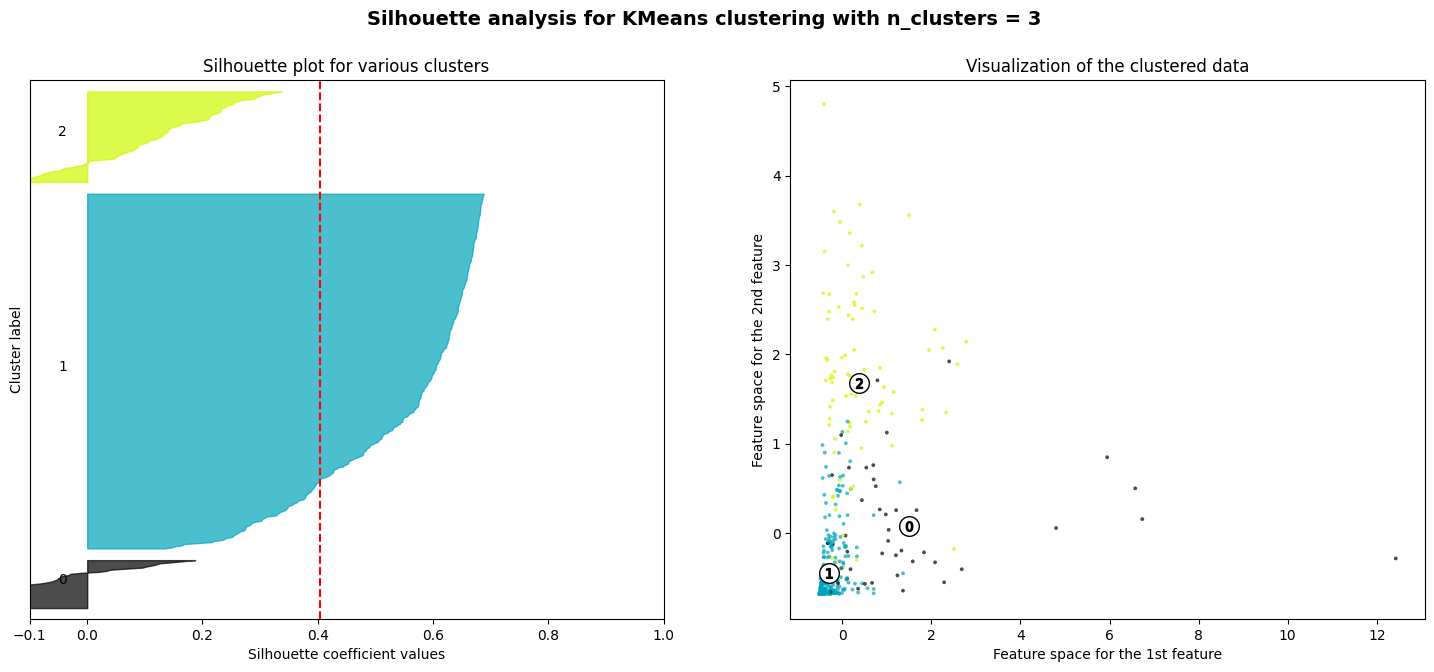

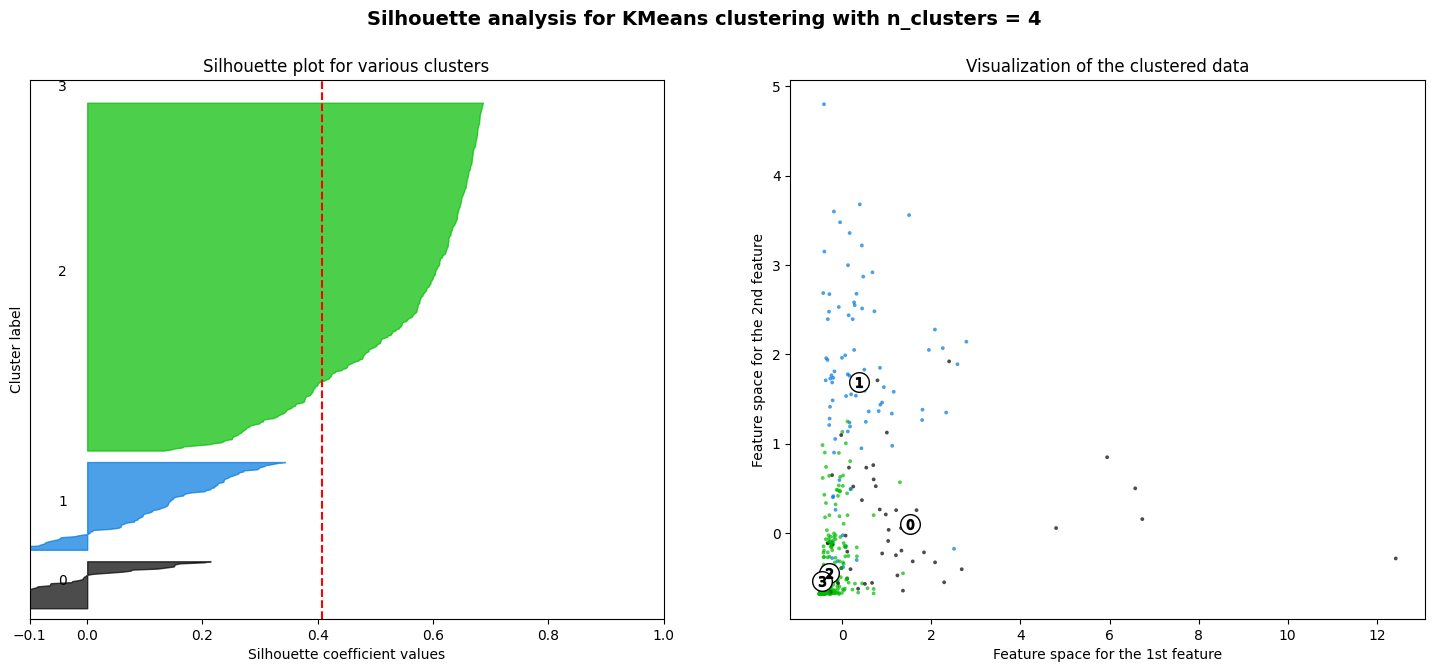

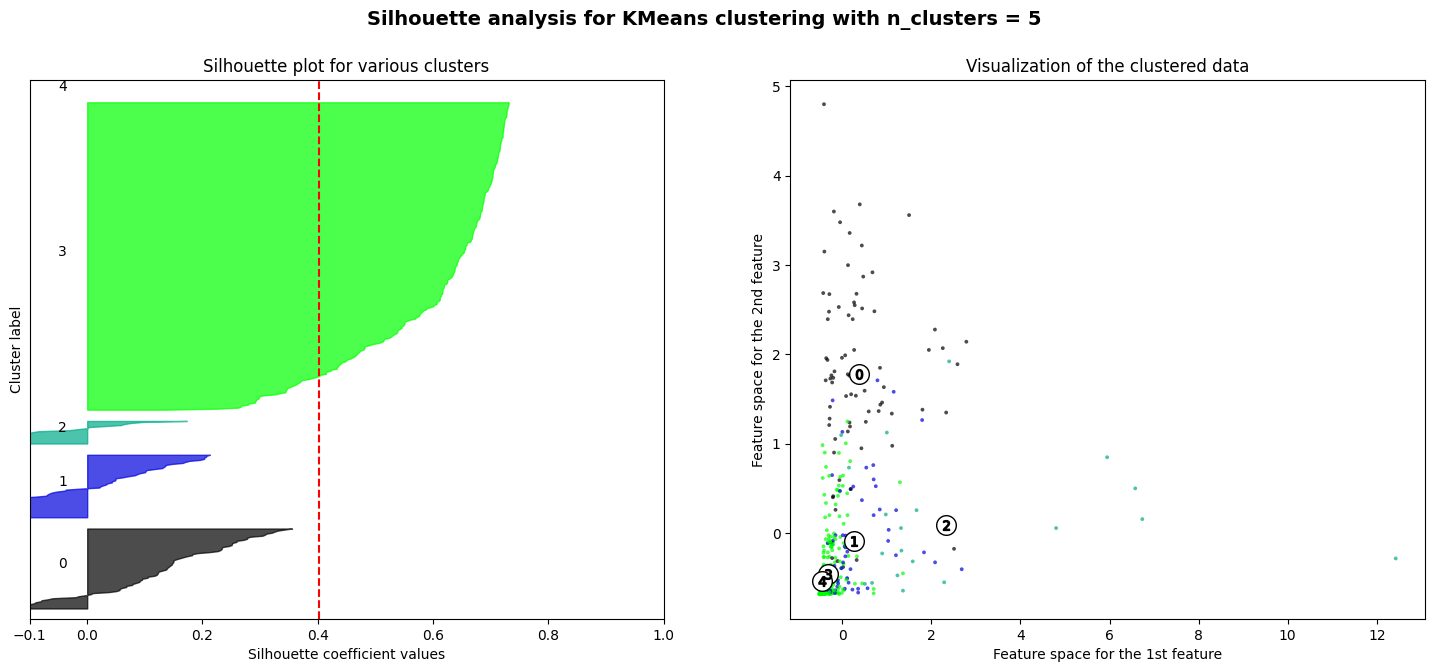

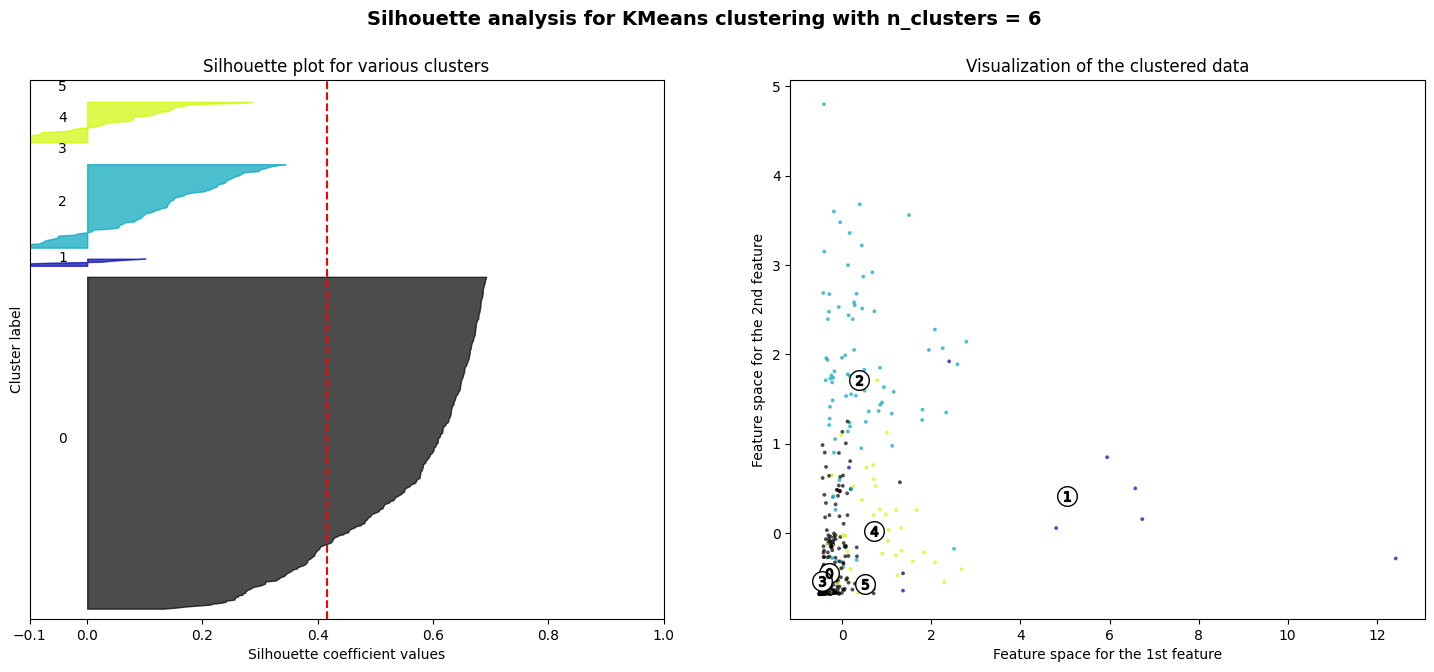

In [19]:
silhouette_analysis(biomarker_df_notcorrelated.values)

Again, it again seems like k=2 is the optimal solution.

In [20]:
biomarker_df_notcorrelated_with_clusters = assign_clusters(biomarker_df_notcorrelated, 2)
biomarker_df_notcorrelated_with_clusters.head()

,balf_Amphiregulin_V1_imputed,balf_Calprotectin_V1_imputed,balf_CD163_V1_imputed,balf_IP-10_chemo_V1_imputed,balf_MCP-1_chemo_V1_imputed,balf_MCP-4_chemo_V1_imputed,balf_TARC_chemo_V1_imputed,balf_IL-15_V1_imputed,balf_IL-17A_V1_imputed,balf_IL-7_V1_imputed,Cluster
0,-0.492915,-0.679906,-0.364026,-0.398849,-0.526441,-0.291255,-0.222259,0.109407,-0.320342,-0.083610,0
1,0.109179,0.444489,0.703246,-0.426586,-0.820222,-0.300766,-0.271759,0.528131,1.692955,0.079621,0
2,-0.070704,-0.171665,-0.357568,-0.343292,-0.462556,-0.279299,-0.234603,-1.061765,-0.237674,-0.482387,0
3,-0.500018,-0.667498,-0.400267,-0.404188,0.343985,-0.233626,-0.241308,0.414804,-0.305904,-0.604054,0
4,0.305407,1.536762,-0.492616,0.012145,-0.704107,-0.270526,-0.194698,-0.918226,-0.199417,0.166189,0


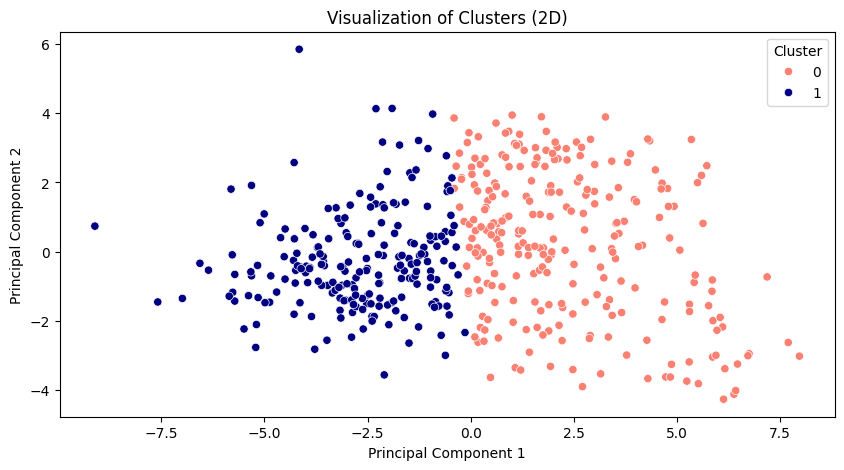

In [21]:
color_palette = ["salmon", "navy"]#, "green"]
visualize_clusters_2D_pca(biomarker_df_with_clusters, colors=color_palette)

In [22]:
visualize_clusters_3D_pca(biomarker_df_with_clusters, colors=color_palette)

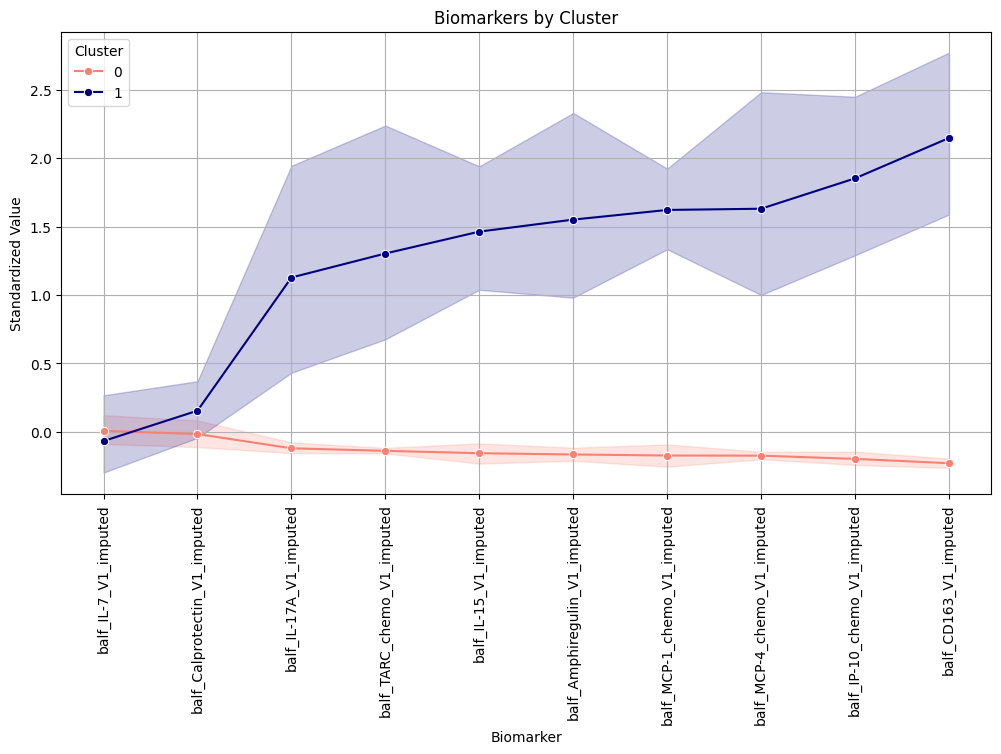

In [23]:
plot_biomarker_clusters(biomarker_df_notcorrelated_with_clusters, cluster_a=0, cluster_b=1, colors=color_palette)

## 4. Model evaluation

In [24]:
X = biomarker_df_notcorrelated_with_clusters.drop(columns=["Cluster"])
y = biomarker_df_notcorrelated_with_clusters["Cluster"]

# Perform a 80-20 train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)

# Train the LASSO model and extract selected biomarkers
best_model, scaler, selected_biomarkers, lasso_results = train_lasso_model(X_train, y_train)

print("\nSelected Key Biomarkers:")
print(selected_biomarkers)

print("\nLASSO Results:")
print(lasso_results)


Selected Key Biomarkers:
['balf_Amphiregulin_V1_imputed' 'balf_Calprotectin_V1_imputed'
 'balf_CD163_V1_imputed' 'balf_IP-10_chemo_V1_imputed'
 'balf_MCP-1_chemo_V1_imputed' 'balf_MCP-4_chemo_V1_imputed'
 'balf_TARC_chemo_V1_imputed' 'balf_IL-15_V1_imputed'
 'balf_IL-17A_V1_imputed']

LASSO Results:
                      Biomarker  Coefficient
0  balf_Amphiregulin_V1_imputed     3.427103
1  balf_Calprotectin_V1_imputed    -1.005013
2         balf_CD163_V1_imputed     5.208225
3   balf_IP-10_chemo_V1_imputed     2.867348
4   balf_MCP-1_chemo_V1_imputed     3.418191
5   balf_MCP-4_chemo_V1_imputed     1.666892
6    balf_TARC_chemo_V1_imputed     2.350977
7         balf_IL-15_V1_imputed     1.946964
8        balf_IL-17A_V1_imputed     0.765343
9          balf_IL-7_V1_imputed     0.000000


In [25]:
# Evaluate the model
auc_val = evaluate_lasso_model(best_model, scaler, X_val, y_val)
print("\nValidation AUC:", auc_val)


Validation AUC: 1.0


Our LASSO-selected biomarkers highlight key signals, with CD163, Amphiregulin, and MCP-1 showing the strongest associations. However, the AUC score of 1 suggests that our model may be overfitting, especially with k=2 clusters, which might be oversimplifying patient differences. To ensure our findings are more robust and biologically meaningful, we plan to explore alternative clustering methods.

## 5. Save data for future reference

In [26]:
biomarker_df_with_clusters.to_csv("../data/clean_data/scaled_biomarker_data_with_clusters.csv", index=False)
biomarker_df_notcorrelated_with_clusters.to_csv("../data/clean_data/scaled_biomarker_data_notcorrelated_with_clusters.csv", index=False)